# Narine Marutyan

In [1]:
import csv
from logs import *
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
EPS = 0.1
BANDIT_REWARD = [1, 2, 3, 4]
NUMBER_OF_TRIALS = 20000

In [3]:
logger = logging.getLogger("MAB Application")
logger.setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

ch.setFormatter(CustomFormatter())

logger.addHandler(ch)

In [4]:
class Bandit(ABC):

    @abstractmethod
    def __init__(self, p):
        self.p = p
        self.N = 0
        self.mean = 0
        self.reward_history = []

    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self, x):
        pass

    @abstractmethod
    def experiment(self, N):
        pass

    @abstractmethod
    def plot1(self):
        pass

    @abstractmethod
    def report(self):
        pass

### Epsilon Greedy

In [5]:
class EpsilonGreedy(Bandit):
    
    def __init__(self, p):
        self.p = p
        self.p_estimate = 0
        self.N = 0
    
    
    def __repr__(self):
        return 'A Bandit with {} Win Rate'.format(self.p)
    
    
    def pull(self):
        return np.random.randn() + self.p
    
    
    def update(self, x):
        self.N += 1
        self.p_estimate = (1 - 1.0/self.N) * self.p_estimate + 1.0/ self.N * x

        
    def experiment(self, bandit_probas, t, N = NUMBER_OF_TRIALS):
        
        bandits = [EpsilonGreedy(p) for p in bandit_probas]
        
        BandSel = []
        means = np.array(bandit_probas)
        true_best = np.argmax(means)  
        count_suboptimal = 0
        sample_points = [10,50,100,500,1000,1500,1999]
        data = np.empty(N)
        eps = 1/t

        for i in range(N):
            

            p = np.random.random()
            
            if p < eps:
                j = np.random.choice(len(bandits))
            else:
                j = np.argmax([b.p_estimate for b in bandits])
            
            x = bandits[j].pull()
            bandits[j].update(x)

            if j != true_best:
                count_suboptimal += 1
            BandSel.append(j)
            data[i] = x
            t = t + 1
            eps = 1/t
        
        global Reward
        Reward = data
        global BandsSel 
        BandsSel = BandSel
        
        cumulative_average = np.cumsum(data) / (np.arange(N) + 1)
        plt.plot(np.cumsum(data), label = "Cumulative Reward")
        plt.xlabel("Number of Trials")
        plt.ylabel("Estimated Reward")
        plt.title("Cummulative reward plot")
        plt.legend()
        plt.show()
        
        df = pd.DataFrame()
        df["BANDIT"] = [b for b in bandits]
        df["REWARD"] = [b.p_estimate for b in bandits]
        df["ALGORITHM NAME"] = "Epsilon Greedy"
        
        global Greedy
        Greedy = df

        for b in bandits:
            print("Estimated average reward where epsilon for {0} = {1} : {2},\n number of times pulled {3}".format(b,eps,b.p_estimate, b.N))
        print("\n")
        print("Percent suboptimal where epsilon = {0} : {1}".format( eps, float(count_suboptimal) / N))
        print("\n")
        print(f'Cummulative average: {cumulative_average}')
        return

    
    def report(self, bandit_probas, N = NUMBER_OF_TRIALS):
        
        bandits = [EpsilonGreedy(p) for p in bandit_probas]
        sum_= []
        for i in BandsSel:
            sum_.append(bandits[i].p)
            
        true_best = max(bandit_probas)
        best_reward = np.arange(N)
        regret = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(Reward)
        plt.plot(regret)
        return
    
    
    def plot1(self):
        pass

### Thompson Sampling

In [6]:
class ThompsonSampling(Bandit):
    
    def __init__(self, true_mean):
        self.true_mean = true_mean
        self.m = 0
        self.lambda_ = 1
        self.tau = 1
        self.N = 0
        self.sum_x = 0
        
    def __repr__(self):
        return 'A Bandit with {} Win Rate'.format(self.true_mean)

    
    def pull(self):
        return np.random.randn()/np.sqrt(self.tau) + self.true_mean

    
    def sample(self):
        return np.random.randn()/np.sqrt(self.lambda_) + self.m

    
    def update(self, x):
        self.m = (self.tau * x + self.lambda_ * self.m) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
    

    def experiment(self, bandit_rewards, NUMBER_OF_TRIALS):
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        bands_selected =[]
        sample_points = [10, 40, 100, 200, 500, 1000, 1500, 4000, 10000, 19999]
        rewards = np.empty(NUMBER_OF_TRIALS)
        for i in range(NUMBER_OF_TRIALS):
            j = np.argmax([b.sample() for b in bandits])

            if i in sample_points:
                self.plot1(bandits, i)

            x = bandits[j].pull()
            bandits[j].update(x)
            rewards[i] = x
            bands_selected.append(j)

        cumulative_average = np.cumsum(rewards) / (np.arange(NUMBER_OF_TRIALS) + 1)
        
        df = pd.DataFrame()
        for b in bandits:
            print("Estimated average reward {0}  {1},\n number of times pulled {2}".format(b,b.m, b.N))
    
        print("\n")
    
        print(f'Cummulative average: {cumulative_average}')
        
        df = pd.DataFrame()
        df["BANDIT"] = [b for b in bandits]
        df["REWARD"] = [b.m for b in bandits]
        df["ALGORITHM NAME"] = "Thompson Sampling"
        
        global reward
        reward = rewards
        global Bands_sel
        Bands_sel = bands_selected
        global Thompson
        Thompson = df
        plt.plot(np.cumsum(rewards), label = "Cumulative reward")
        plt.legend()
        plt.show()
        return cumulative_average
    
    
    def plot1(self, bandits, trial):
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label = f"real mean: {b.true_mean:.4f}, num plays: {b.N}")
            plt.title("Bandit distributions after {} trials".format(trial))
        plt.legend()
        plt.show()
        pass
       
        
    def report(self, bandit_rewards, N = NUMBER_OF_TRIALS):
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        sum_= []
        for i in Bands_sel:
            sum_.append(bandits[i].true_mean)
        true_best = max(bandit_rewards)
        best_reward = np.arange(N) 
        regret = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(reward)
        plt.plot(regret)
        return

In [7]:
eps = EpsilonGreedy(Bandit)

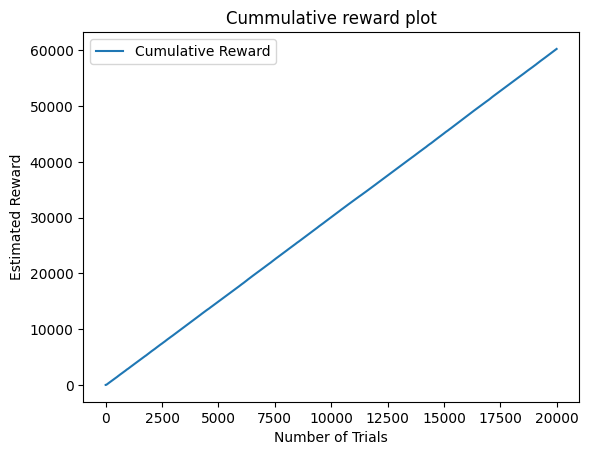

Estimated average reward where epsilon for A Bandit with 1 Win Rate = 4.9975012493753125e-05 : 0.7471632154562999,
 number of times pulled 31
Estimated average reward where epsilon for A Bandit with 2 Win Rate = 4.9975012493753125e-05 : 0.46411108377703925,
 number of times pulled 1
Estimated average reward where epsilon for A Bandit with 3 Win Rate = 4.9975012493753125e-05 : 3.016722950718482,
 number of times pulled 19968
Estimated average reward where epsilon for A Bandit with 4 Win Rate = 4.9975012493753125e-05 : 0,
 number of times pulled 0


Percent suboptimal where epsilon = 4.9975012493753125e-05 : 1.0


Cummulative average: [2.54925448 0.83868643 0.7040753  ... 3.01311288 3.01304339 3.0130775 ]


In [8]:
eps.experiment(BANDIT_REWARD, 10)

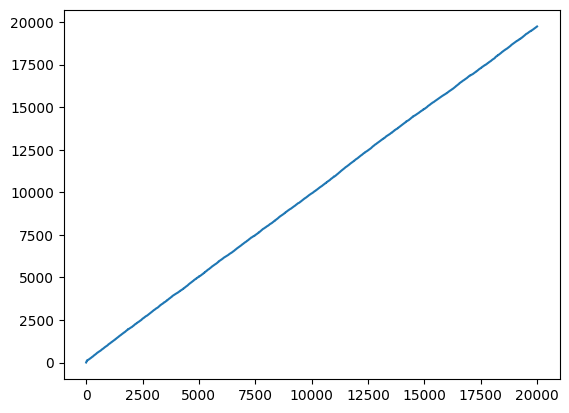

In [9]:
eps.report(BANDIT_REWARD)

In [10]:
thomp = ThompsonSampling(Bandit)

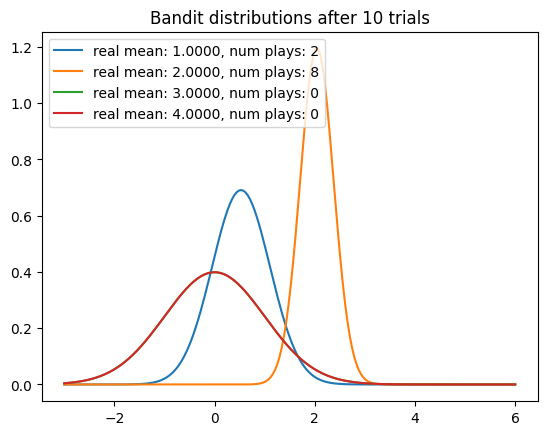

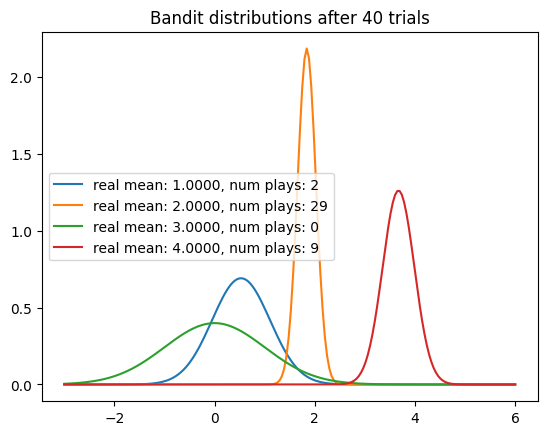

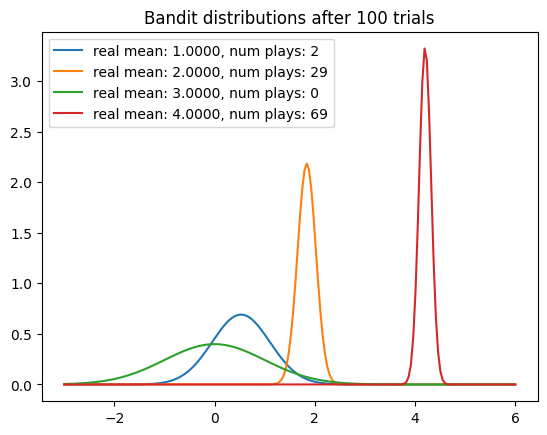

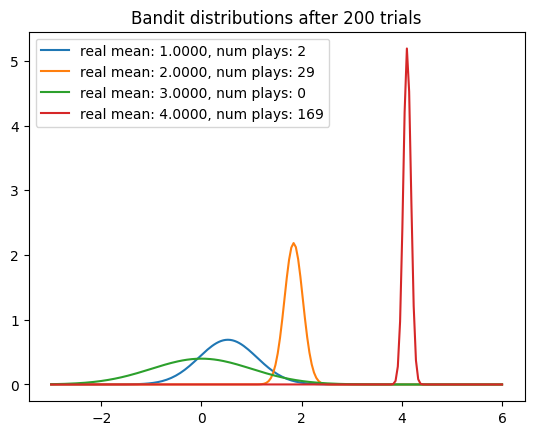

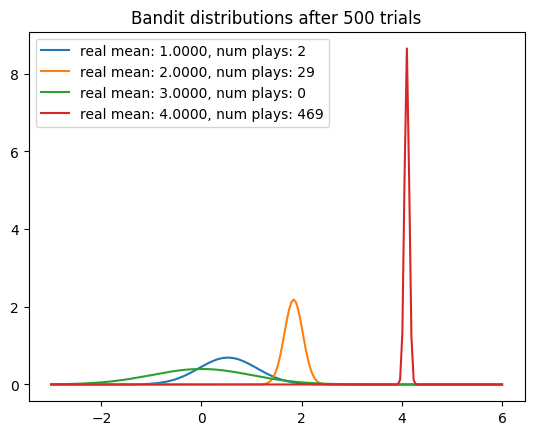

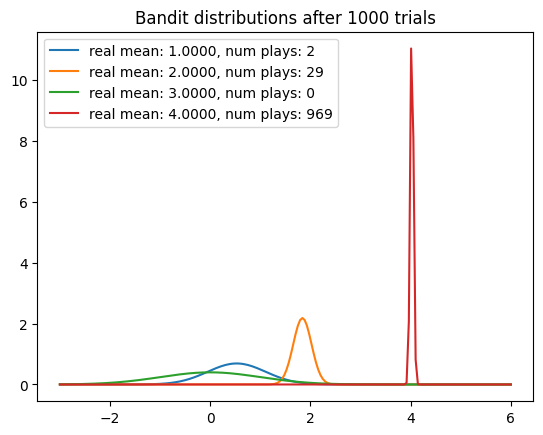

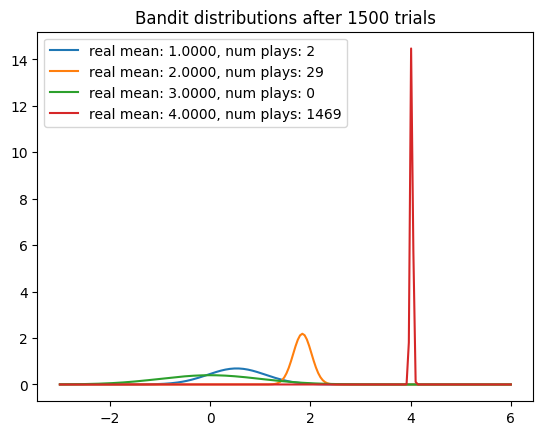

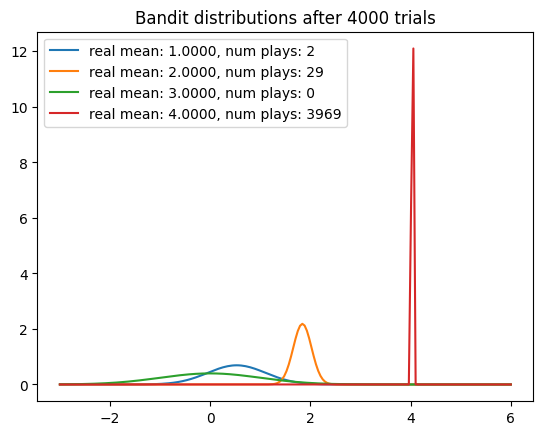

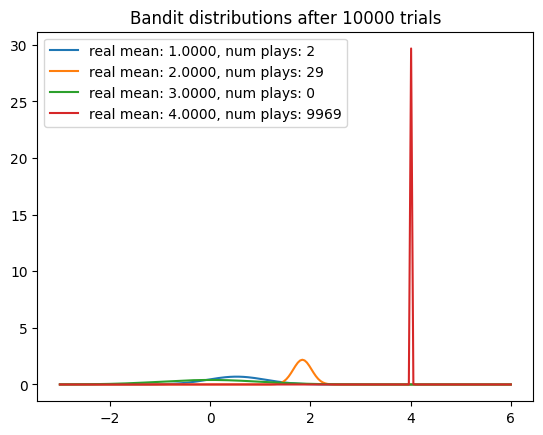

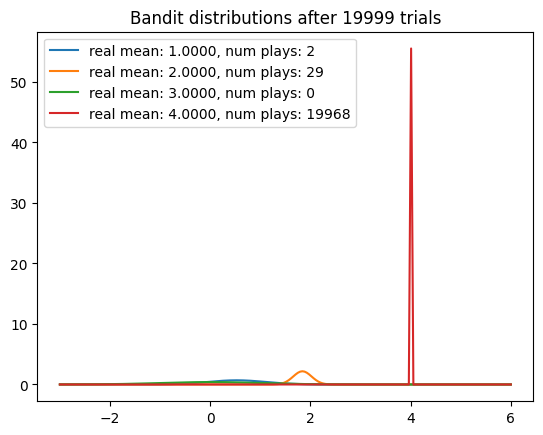

Estimated average reward A Bandit with 1 Win Rate  0.5281815574269678,
 number of times pulled 2
Estimated average reward A Bandit with 2 Win Rate  1.8403751778928796,
 number of times pulled 29
Estimated average reward A Bandit with 3 Win Rate  0,
 number of times pulled 0
Estimated average reward A Bandit with 4 Win Rate  4.008812263038263,
 number of times pulled 19969


Cummulative average: [2.50886509 0.79227234 1.45352327 ... 4.00560441 4.00563811 4.00563883]


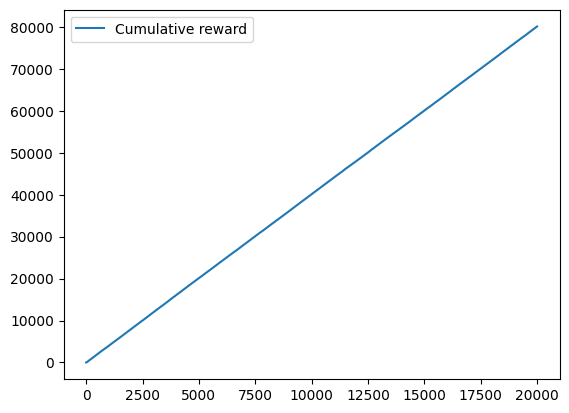

array([2.50886509, 0.79227234, 1.45352327, ..., 4.00560441, 4.00563811,
       4.00563883])

In [11]:
thomp.experiment(BANDIT_REWARD, NUMBER_OF_TRIALS)

### Storing the rewards in a CSV file

In [12]:
EpsilonGreedy1 = pd.DataFrame({"Bandit" : BandsSel, 
                               "Reward" : reward, 
                               "Algorithm" : "Epsilon Greedy"})

In [13]:
Thompson1 = pd.DataFrame({"Bandit" : Bands_sel,
                          "Reward" : reward, 
                          "Algorithm" : "Thompson Sampling"})

In [14]:
Final_EpsilonGreedy = Greedy
Final_Thompson = Thompson
Final_Thompson.to_csv("Final_Thompson.csv")
Final_EpsilonGreedy.to_csv("Final_EpsilonGreedy.csv")
Thompson1.to_csv("All_Thompson.csv")
EpsilonGreedy1.to_csv("All_EpsilonGreedy.csv")